In [1]:
!pip install numba-scipy

In [2]:
import numpy as np
from numba import njit, cfunc

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy as sy
import json
import pickle
from numpy.linalg import norm

from time import time
from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint, quad, solve_ivp
from scipy.special import lpmn, lpmv, jv, jnyn_zeros, j0, j1
from scipy.stats import rv_continuous

In [3]:
R_earth = 6400000.
R_moon = 1737100.
dist_moon = 380000000.
R_m = 16 * R_earth
b = 5 * R_earth
phi_ecl = np.pi / 36
cos_ecl = cos(phi_ecl)
sin_ecl = sin(phi_ecl)
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
k_b = 1.38e-23
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
c = 3e8 #м/с
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10


maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q

In [4]:
def create_const_a(N=100):
    jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 10)
    x_0 = jnp_roots
    jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 10)
    x_1 = jnp_roots
    
    def f0(x):
            S = -b / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += -1 / b ** 2 * (n + 1) * (-b / R_m) ** (n + 1) * (x / R_m) ** n * lpmv(0, n, 0)
            return S


    def f1(x):
            S = x / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += 1 / b ** 2 * (n + 1) / n * (-b / R_m) ** (n + 1) * (x / R_m) ** n * (-lpmv(1, n, 0))
            return S

    def func(x, x_nn, v):
        if v == 0:
            return x * jv(0, x_nn * x / R_m) * f0(x)
        else:
            return x * jv(1, x_nn * x / R_m) * f1(x)


    a_0 = np.array([2 / (R_m ** 2 * jv(0, x_0[n]) ** 2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in
                    tqdm(range(N), desc="Подсчет a_0")])
    a_1 = np.array(
        [2 / (R_m ** 2 * jv(1, x_1[n]) ** 2 * (1 - (1 / x_1[n]) ** 2)) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for
         n in tqdm(range(N), desc="Подсчет a_1")])
    return a_0, a_1, x_0, x_1

In [5]:
N=10

a_0, a_1, x_0, x_1 = create_const_a(N=N)

ns = np.arange(1, N+1)
R_m_arr = np.array([R_m]*N)
m_x_arr = np.array([m_x]*N)
m_y_arr = np.array([m_y]*N)
m_z_arr = np.array([m_z]*N)
mu_0_arr = np.array([mu_0]*N)

Подсчет a_1: 100%|██████████| 10/10 [00:00<00:00, 39.29it/s]


In [6]:
@njit(cache=True)
def legs(theta):

    cos_theta = cos(theta)
    sin_theta = sin(theta)

    legs_0n = np.array([cos_theta, 1 / 2 * (3 * cos_theta ** 2 - 1),
                        1 / 2 * (5 * cos_theta ** 3 - 3 * cos_theta),
                        1 / 8 * (35 * cos_theta ** 4 - 30 * cos_theta ** 2 + 3),
                        1 / 8 * (63 * cos_theta ** 5 - 70 * cos_theta ** 3 + 15 * cos_theta),
                        1 / 16 * (231 * cos_theta ** 6 - 315 * cos_theta ** 4 + 105 * cos_theta ** 2 - 5),
                        1 / 16 * (
                                    429 * cos_theta ** 7 - 693 * cos_theta ** 5 + 315 * cos_theta ** 3 - 35 * cos_theta),
                        1 / 128 * (
                                    6435 * cos_theta ** 8 - 12012 * cos_theta ** 6 + 6930 * cos_theta ** 4 - 1260 * cos_theta ** 2 + 35),
                        1 / 128 * (
                                    12155 * cos_theta ** 9 - 25740 * cos_theta ** 7 + 18018 * cos_theta ** 5 - 4620 * cos_theta ** 3 + 315 * cos_theta),
                        1 / 256 * (
                                    46189 * cos_theta ** 10 - 109395 * cos_theta ** 8 + 90090 * cos_theta ** 6 - 30030 * cos_theta ** 4 + 3465 * cos_theta ** 2 - 63)]
                       )
    legs_1n = np.array([np.abs(sin_theta), 3 * cos_theta * np.abs(sin_theta),
                        3 / 2 * np.abs(sin_theta) * (5 * cos_theta ** 2 - 1),
                        5 / 2 * np.abs(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                        15 / 8 * np.abs(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                        21 / 8 * np.abs(sin_theta) * (33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                        7 / 16 * np.abs(sin_theta) * (
                                    429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                        9 / 16 * np.abs(sin_theta) * (
                                    715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                        45 / 128 * np.abs(sin_theta) * (
                                    2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                        55 / 128 * np.abs(sin_theta) * (
                                    4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                       )
    divlegs_0n = np.array([-sin_theta, -3 * sin_theta * cos_theta,
                           -3 / 2 * sin_theta * (5 * cos_theta ** 2 - 1),
                           -5 / 2 * sin_theta * cos_theta * (7 * cos_theta ** 2 - 3),
                           -15 / 8 * sin_theta * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                           -21 / 8 * sin_theta * cos_theta * (33 * cos_theta ** 4 - 30 * cos_theta ** 2 + 5),
                           -7 / 16 * sin_theta * (
                                       429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                           -9 / 16 * sin_theta * cos_theta * (
                                       715 * cos_theta ** 6 - 1001 * cos_theta ** 4 + 385 * cos_theta ** 2 - 35),
                           -45 / 128 * sin_theta * (
                                       2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                           -55 / 128 * sin_theta * cos_theta * (
                                       4199 * cos_theta ** 8 - 7956 * cos_theta ** 6 + 4914 * cos_theta ** 4 - 1092 * cos_theta ** 2 + 63)]
                          )
    divlegs_1n = np.array([cos_theta * np.sign(sin_theta), -3 * np.sign(sin_theta) * (1 - 2 * cos_theta ** 2),
                           -3 / 2 * np.sign(sin_theta) * cos_theta * (11 - 15 * cos_theta ** 2),
                           5 / 2 * np.sign(sin_theta) * (28 * cos_theta ** 4 - 27 * cos_theta ** 2 + 3),
                           15 / 8 * np.sign(sin_theta) * cos_theta * (
                                       105 * cos_theta ** 4 - 126 * cos_theta ** 2 + 29),
                           21 / 8 * np.sign(sin_theta) * (
                                       198 * cos_theta ** 6 - 285 * cos_theta ** 4 + 100 * cos_theta ** 2 - 5),
                           7 / 16 * np.sign(sin_theta) * cos_theta * (
                                       3003 * cos_theta ** 6 - 5049 * cos_theta ** 4 + 2385 * cos_theta ** 2 - 275),
                           9 / 16 * np.sign(sin_theta) * (
                                       5720 * cos_theta ** 8 - 11011 * cos_theta ** 6 + 6545 * cos_theta ** 4 - 1225 * cos_theta ** 2 + 35),
                           45 / 128 * np.sign(sin_theta) * cos_theta * (
                                       21879 * cos_theta ** 8 - 47476 * cos_theta ** 6 + 34034 * cos_theta ** 4 - 8932 * cos_theta ** 2 + 623),
                           55 / 128 * np.sign(sin_theta) * (
                                       41990 * cos_theta ** 10 - 101439 * cos_theta ** 8 + 85176 * cos_theta ** 6 - 28938 * cos_theta ** 4 + 3402 * cos_theta ** 2 - 63)]
                          )
    legs_1n_div_sin = np.array([np.sign(sin_theta), 3 * cos_theta * np.sign(sin_theta),
                                3 / 2 * np.sign(sin_theta) * (5 * cos_theta ** 2 - 1),
                                5 / 2 * np.sign(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                                15 / 8 * np.sign(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                                21 / 8 * np.sign(sin_theta) * (
                                            33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                                7 / 16 * np.sign(sin_theta) * (
                                            429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                                9 / 16 * np.sign(sin_theta) * (
                                            715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                                45 / 128 * np.sign(sin_theta) * (
                                            2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                                55 / 128 * np.sign(sin_theta) * (
                                            4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                               )

    return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin

In [7]:
@njit
def meshgrid(x, y, z):
    xx = np.empty(shape=(x.size, y.size, z.size), dtype=x.dtype)
    yy = np.empty(shape=(x.size, y.size, z.size), dtype=y.dtype)
    zz = np.empty(shape=(x.size, y.size, z.size), dtype=z.dtype)
    for i in range(x.size):
        for j in range(y.size):
            for k in range(z.size):
                xx[i,j,k] = x[i]  # change to x[k] if indexing xy
                yy[i,j,k] = y[j]  # change to y[j] if indexing xy
                zz[i,j,k] = z[k]  # change to z[i] if indexing xy
    return xx, yy, zz


@njit
def make_start_points_for_magnetosphere(thetha_nums=10, phi_nums=10):
    theta = np.linspace(0, np.pi, thetha_nums)
    phi = np.linspace(0, 2 * np.pi, phi_nums)
    r = np.linspace(R_earth, R_earth, 1)
    

    th, ph, rr = meshgrid(theta, phi, r)

    th = np.expand_dims(th, axis=-1)
    ph = np.expand_dims(ph, axis=-1)
    rr = np.expand_dims(rr, axis=-1)

    start_points = np.concatenate((rr, th, ph), axis=-1)
    start_points = start_points.reshape(-1, 3)
    return start_points


@njit(cache=True)
def sphere_to_decart(point, B):
    r, theta, phi = point
    C = np.array([[sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)],
                  [cos(theta) * cos(phi), cos(theta) * sin(phi), -sin(theta)],
                  [-sin(phi), cos(phi), 0]])
    B_xyz = B @ C
    point_xyz = np.array([r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)])
    return B_xyz, point_xyz

@njit(cache=True)
def decart_to_sphere(x, y, z, eps=1e-8):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
    return np.array([r, theta, phi])

@njit(cache=True)
def spher_to_cyl(point):
    r, theta, phi = point

    rho = r * sin(theta)
    phi = phi
    z = r * cos(theta)

    return rho, phi, z

@njit(cache=True)
def cyl_to_dec(point, B):
    rho, phi, z = spher_to_cyl(point)
    C = np.array([[cos(phi), -sin(phi), 0.],
                  [sin(phi), cos(phi), 0.],
                  [0., 0., 1.]]
                 )
    B_xyz = C @ B
    point_xyz = np.array([rho * cos(phi), rho * sin(phi), z])
    return B_xyz, point_xyz


In [8]:
@njit
def conf_B_tail(point, lambd):
    rho, phi, z = spher_to_cyl(point)

    jv_1x_0 = np.array([j1(x_0[i] * rho / R_m) for i in range(N)])
    jv_1x_1 = np.array([j1(x_1[i] * rho / R_m) for i in range(N)])
    jv_0x_1 = np.array([j0(x_1[i] * rho / R_m) for i in range(N)])
    jv_0x_0 = np.array([j0(x_0[i] * rho / R_m) for i in range(N)])
    jv_2x_1 = np.array([jv(2., x_1[i] * rho / R_m) for i in range(N)])

    cos_phi = np.array([cos(phi)]*N)
    sin_phi = np.array([sin(phi)]*N)
    expx_1 = np.exp(-x_1[:N] * z / R_m)
    expx_0 = np.exp(-x_0[:N] * z / R_m)
    explambdx_1 = np.exp(-lambd * x_1[:N] * z / R_m)
    explambdx_0 = np.exp(-lambd * x_0[:N] * z / R_m)
    mu_0_arr = np.array([mu_0/(4*np.pi)]*N)

    res = [mu_0_arr / R_m_arr * (
                     (x_0 * a_0 * m_x_arr  * jv_1x_0 * (expx_0 + lambd*explambdx_0)
                      + 0.5 * x_1 * a_1 * (m_z_arr * cos_phi + m_y_arr * sin_phi)* (jv_2x_1 - jv_0x_1) * (expx_1 + lambd*explambdx_1)
                                                 )
                       ),
                     a_1 * mu_0_arr / rho * (
                         (m_z_arr * sin_phi - m_y_arr * cos_phi)* jv_1x_1 * (expx_1 + lambd * explambdx_1)
                       ),
                      mu_0_arr / R_m_arr * (
                          x_0  * a_0 * m_x_arr * jv_0x_0 * (expx_0 + explambdx_0)
                          + x_1 * a_1 * (m_z_arr * cos_phi + m_y_arr * sin_phi) * jv_1x_1 * (expx_1 + explambdx_1)
                                             )
                       ]

    res_sum = np.empty(len(res))
    for i in range(len(res)):
        res_sum[i] = np.sum(res[i])
    return res_sum / 2

@njit(cache=True)
def conf_B_sphere_cfa(point, B_imf_xyz):
    r, theta, phi = point

    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    B_cfa_r = - (R_m / r) ** 3 * (
                B_imf_xyz[2] * legs_0n[0] + B_imf_xyz[0] * cos(phi) * legs_1n[0] + B_imf_xyz[1] * sin(phi) *
                legs_1n[0])
    B_cfa_theta = 0.5 * (R_m / r) ** 3 * (
                B_imf_xyz[2] * divlegs_0n[0] + B_imf_xyz[0] * cos(phi) * divlegs_1n[0] + B_imf_xyz[1] * sin(phi) *
                divlegs_1n[0])
    B_cfa_phi = 0.5 * (R_m / r) ** 3 * (
                -B_imf_xyz[0] * sin(phi) * legs_1n_div_sin[0] + B_imf_xyz[1] * cos(phi) * legs_1n_div_sin[0])
    return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

@njit(cache=True)
def conf_B_cyl_cfa(point, B_imf_xyz):
    rho, phi, z = spher_to_cyl(point)
    R_mrho = (R_m / rho) ** 2
    B_cfa_rho = - R_mrho * (B_imf_xyz[0] * cos(phi) + B_imf_xyz[1] * sin(phi))
    B_cfa_phi = R_mrho * (-B_imf_xyz[0] * sin(phi) + B_imf_xyz[1] * cos(phi))
    B_cfa_z = 0
    return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])

@njit(cache=True)
def conf_B_dip_xyz_M(point):
    r_M, theta_M, phi_M = point
    x_M, y_M, z_M = r_M * sin(theta_M) * cos(phi_M), r_M * sin(theta_M) * sin(phi_M), r_M * cos(theta_M)

    r = np.sqrt((z_M + b) ** 2 + y_M ** 2 + x_M ** 2)

    R_r3 = (R_earth / r) ** 3
    R_r35 = (R_earth) ** 3 / (r ** 5)

    B_x = -R_r3 * g_10 + 3 * R_r35 * x_M * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    B_y = -R_r3 * h_11 + 3 * R_r35 * y_M * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    B_z = R_r3 * g_11 + 3 * R_r35 * (z_M + b) * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

@njit(cache=True)
def conf_B_cfi_N(point):
    r, theta, phi = point  # r_m, theta_m, phi_m

    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    cos_phi = cos(phi)
    sin_phi = sin(phi)
    mu_0_with_b = mu_0 / (4 * np.pi * b ** 3)

    res = [mu_0_with_b * (ns + 1) * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      -ns * m_x * legs_0n[:N] + (m_z * cos_phi + m_y * sin_phi) * legs_1n[:N]
              ),
              mu_0_with_b * (ns + 1) / ns * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      -ns * m_x * divlegs_0n[:N] + (m_z * cos_phi + m_y * sin_phi) * divlegs_1n[:N]
              ),
              mu_0_with_b * (ns + 1) / ns * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      (-m_z * sin_phi + m_y * cos_phi) * legs_1n_div_sin[:N])]
    
    res_sum = np.empty(len(res))
    for i in range(len(res)):
        res_sum[i] = np.sum(res[i])
    return res_sum

@njit
def conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz):
    x, y, z = point_xyz
    point = decart_to_sphere(x, y, z)  # x_m, y_m, z_m -> r_m, theta_m, phi_m

    # проверка в цилиндре мы или в полусфере
    if point_xyz[-1] < 0 and point[0] < R_m:

        B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)

        B_cfi = conf_B_cfi_N(point)
        B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)

        B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a * B_imf_xyz
    elif point_xyz[-1] > 0 and point[0] * sin(point[1]) < R_m:

        B_tail = conf_B_tail(point, lambd)
        B_tail_xyz, point_tail_xyz = cyl_to_dec(point, B_tail)

        B_xyz = B_tail_xyz + C_a * B_imf_xyz
    elif point_xyz[-1] < 0 and point[0] >= R_m:
        B_cfa = conf_B_sphere_cfa(point, B_imf_xyz)
        B_cfa_xyz, point_cfa_xyz = sphere_to_decart(point, B_cfa)

        B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
    else:
        B_cfa_cyl = conf_B_cyl_cfa(point, B_imf_xyz)
        B_cfa_cyl_xyz, point_cfa_cyl_xyz = cyl_to_dec(point, B_cfa_cyl)

        B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz

    return B_xyz

In [9]:
def make_Earth(data=None):
    def ms(x, y, z, radius, resolution=20):
        """Return the coordinates for plotting a sphere centered at (x,y,z)"""
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        X = radius * np.cos(u) * np.sin(v) + x
        Y = radius * np.sin(u) * np.sin(v) + y
        Z = radius * np.cos(v) + z
        return (X, Y, Z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
    data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
    return data


def make_Moon(data=None):
    def ms(x, y, z, radius, resolution=20):
        """Return the coordinates for plotting a sphere centered at (x,y,z)"""
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        X = radius * np.cos(u) * np.sin(v) + x
        Y = radius * np.sin(u) * np.sin(v) + y
        Z = radius * np.cos(v) + z
        return (X, Y, Z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b + dist_moon, 0, 0, R_moon)
    data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
    return data

def make_torus(data=None):
    def supertorus(R_out, R_in, resolution=20):
        #  initial range for values used in parametric equation
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        x = (R_out + R_in*np.sin(v)) * np.cos(u)
        y = (R_out + R_in*np.sin(v)) * np.sin(u)
        z = R_in*np.cos(v)

        x = x*cos_ecl - z*sin_ecl - b
        y = y
        z = z*cos_ecl + x*sin_ecl

        return (x, y, z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = supertorus(dist_moon, R_moon)
    data.append(go.Surface(x=x_pns_surface,
                           y=y_pns_surface,
                           z=z_pns_suraface,
                           opacity=0.5))
    return data

def plot_image(data):
    fig = go.Figure(data=data)
    fig.update_layout(coloraxis_showscale=False)
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,
        scene=dict(
                 aspectmode='data'
         ))
    fig.for_each_annotation(lambda a: a.update(text=""))
    fig.show()


In [10]:
def make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10, data=None):
    data = [] if data is None else data
    for point in tqdm(make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
        r = point[0]
        step = -1 if point[1] < np.pi / 2 else 1
        X = []
        Y = []
        Z = []
        i = 0

        r, theta, phi = point

        x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
        x_M, y_M, z_M = z, y, -(x + b)
        point_xyz = np.array([x_M, y_M, z_M])

        while R_earth <= r <= 2 * R_m and i < maxiter:

            X += [point_xyz[0]]
            Y += [point_xyz[1]]
            Z += [point_xyz[2]]

            B_xyz = conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

            # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
            # этого
            if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e5
            else:
                point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e6

            x, y, z = point_xyz

            r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
            i += 1

        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]

        X = np.array(X)
        Y = np.array(Y)
        Z = np.array(Z)

        data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                 marker=dict(
                                     size=0.1,
                                     color='blue',  # set color to an array/list of desired values
                                     colorscale=None,  # choose a colorscale
                                     opacity=0.8
                                 ),
                                 showlegend=False
                                 )
                    )
    return data

@njit
def find_cusp(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10):
    R = []
    Thetha = []
    Phi = []
    for start_point in make_start_points_for_magnetosphere(thetha_nums, phi_nums):
        r = start_point[0]
        step = -1 if start_point[1] < np.pi / 2 else 1
        i = 0

        r, theta, phi = start_point

        x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
        x_M, y_M, z_M = z, y, -(x + b)
        point_xyz = np.array([x_M, y_M, z_M])

        while R_earth <= r <= 2 * R_m and i < maxiter:

            B_xyz = conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

            # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
            # этого
            if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                point_xyz = point_xyz + step * B_xyz / norm(B_xyz) * 1e5
            else:
                point_xyz = point_xyz + step * B_xyz / norm(B_xyz) * 1e6

            x, y, z = point_xyz

            r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
            i += 1

        if r >= R_earth:
            R.append(start_point[0])
            Thetha.append(start_point[1])
            Phi.append(start_point[2])

    return np.array(R), np.array(Thetha), np.array(Phi)

@njit(cache=True)
def points_from_cusp(thetha):
    thetha_up = thetha[thetha < np.pi / 2]
    thetha_down = thetha[thetha > np.pi / 2]

    th_up_n, th_down_n = max(thetha_up), min(thetha_up)
    th_up_s, th_down_s = max(thetha_down), min(thetha_down)

    return th_up_n, th_down_n, th_up_s, th_down_s

@njit(cache=True)
def if_in_tor(point_xyz):
    C = np.array([[cos_ecl, 0., -sin_ecl],
                  [0., 1., 0.],
                  [sin_ecl, 0., cos_ecl]])
    new_point = C @ point_xyz
    if new_point[1] == 0 and new_point[2] == 0:
        new_point = np.array([new_point[0], 0., 0.])
    else:
        new_point -= dist_moon / (np.sqrt(new_point[1]**2 + new_point[2]**2)) * np.array([0, new_point[1], new_point[2]])
    return norm(new_point) < R_moon


In [11]:
@njit
def pend(y, t, q, m, C_i, C_a, lambd, v_start, step):
        y1, y2, y3, y4, y5, y6 = y
        point = np.array([y1, y3, y5])
        r = y1 ** 2 + y3 ** 2 + (y5 + b) ** 2
        if (r <= R_earth**2
            or r >= (1.1*dist_moon)**2
            or if_in_tor(np.array([y1, y3, y5 + b]))
            or (t > 600*109/v_start and r <= (10*R_earth)**2)
           ):
            return [0., 0., 0., 0., 0., 0.]
        B_xyz = conf_B(point, C_i, C_a, lambd, B_imf_xyz)
        v_xyz = np.array([y2, y4, y6])
        acc_dir = step*B_xyz / norm(B_xyz)
        if t <= 660:
            if r < 64*R_earth**2:
                f = [y2,
                     q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]) + 12*acc_dir[0],
                     y4,
                     q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]) + 12*acc_dir[1],
                     y6,
                     q / m * (y2 * B_xyz[1] - y4 * B_xyz[0]) + 12*acc_dir[2]]
            elif r > 91*R_earth**2:
                f = [y2,
                     q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]) + 70*acc_dir[0],
                     y4,
                     q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]) + 70*acc_dir[1],
                     y6,
                     q / m * (y2 * B_xyz[1] - y4 * B_xyz[0]) + 70*acc_dir[2]]
            else:
                f = [y2,
                     q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]) + 100*acc_dir[0],
                     y4,
                     q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]) + 100*acc_dir[1],
                     y6,
                     q / m * (y2 * B_xyz[1] - y4 * B_xyz[0]) + 100*acc_dir[2]]
        else:
            f = [y2,
                 q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]) + 60*acc_dir[0] / (r / R_earth),
                 y4,
                 q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]) + 60*acc_dir[1] / (r / R_earth),
                 y6,
                 q / m * (y2 * B_xyz[1] - y4 * B_xyz[0]) + 60*acc_dir[2] / (r / R_earth)]
        return f

In [12]:
def count_particles(C_i, C_a, lambd, B_imf_xyz, m_particles, q_particles,
                    plotdata=False, data=None, download=False):


    data = [] if data is None else data

    if download:
        try:
            with open("/kaggle/input/progress/probabilities.txt", "rb") as f:
                prob = pickle.load(f)
        except IOError:
            prob = Probabilities()
    else:
        prob = Probabilities()

    pbar = tqdm()
    while True:
        try:
            theta, phi, r, theta_v, phi_v, v, start_north = prob()
            x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
            x_M, y_M, z_M = z, y, -(x + b)

            v_x, v_y, v_z = v * sin(theta_v) * cos(phi_v), v * sin(theta_v) * sin(phi_v), v * cos(theta_v)
            v_xM, v_yM, v_zM = v_z, v_y, -v_x

            # x, v_x, y, v_y, z, v_z
            y0 = [x_M, v_xM,
                  y_M, v_yM,
                  z_M, v_zM]
            dt = 0.05 * 346064 / v
            t = np.linspace(0, 5000, int(5000 / dt))
            step = -1 if start_north else 1

            sol = odeint(pend, y0, t, args=(q_particles, m_particles, C_i, C_a, lambd, v*1e-3, step))

            X = sol[:, 0]
            Y = sol[:, 2]
            Z = sol[:, 4]
            if plotdata:
                data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                         marker=dict(
                                             size=0.1,
                                             color='orange',  # set color to an array/list of desired values
                                             colorscale=None,  # choose a colorscale
                                             opacity=0.8
                                         )
                                         )
                            )

            point = np.array([X[-1], Y[-1], Z[-1] + b])
            if if_in_tor(point):
                prob.count += 1
                if point[-1] > 0:
                    prob.count_behind += 1
#                     prob.traj += [[X, Y, Z]]
                prob.dep += 1
            elif sum(point**2) >= (10*R_earth)**2:
                prob.dep += 1
            prob.n += 1

            if prob.n in (1000, 5000, 10000, 50000, 100000, 500000, 1000000):
                prob.save += [[prob.n, prob.count, prob.dep, prob.count_behind]]

            pbar.set_description(f'Запущено: {prob.n}, ' 
                                 f'Упало: {prob.count}, '
                                 f'Улетевших с Земли: {prob.dep}, '
                                 f'Процент упавших: {prob.count / prob.dep * 100:0.2f}%, '
                                 f'Процент упавших позади Земли: {prob.count_behind / prob.dep * 100:0.2f}%, '
                                 f'Процент улетевших: {prob.dep / prob.n * 100:0.2f}%'
                                 )
            pbar.update(1)
        except KeyboardInterrupt:
            # this is really rude to do, by the by....
            print("Сохранение и выход")
            with open("probabilities.txt", "wb") as f:
                pickle.dump(prob, f)
            break
    pbar.close()
    return data, prob.count

In [13]:
class Probabilities:
    def __init__(self):
        
        self.thetha_np = self.thetha_north_pole(th_down_n, th_up_n, name='thetha_norht_pole', a=th_down_n, b=th_up_n)
        self.phi_np = self.phi_north_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.thetha_sp = self.thetha_south_pole(th_down_s, th_up_s, name='thetha_south_pole', a=th_down_s, b=th_up_s)
        self.phi_sp = self.phi_south_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.r_dist = self.R_dist(name='R_dist', a=7*R_earth, b=10*R_earth)
        self.v_t = self.v_thetha(name='v_thetha', a=0, b=2*np.pi)
        self.v_p = self.v_phi(name='v_phi', a=0, b=2*np.pi)
        self.w_dist = self.W_dist(name='R_dist', a=0, b=np.inf)
        self.count = 0
        self.count_behind = 0
        self.n = 1
        self.dep = 1
        self.traj = []
        self.save = []
        
    @staticmethod
    def w2v(w, m_particles=16*m):
            return c*np.sqrt(1-1/(1+(w*q)/(m_particles*c**2))**2)
    
    def __call__(self):
        try:
            if np.random.randint(2):
                return self.thetha_np.rvs(), self.phi_np.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3), True  
            return self.thetha_sp.rvs(), self.phi_sp.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3), False
        except:
            return self.__call__()
        
    class thetha_north_pole(rv_continuous):
        def __init__(self, th_down_n, th_up_n, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_n = th_down_n
            self.th_up_n = th_up_n
        def _pdf(self, x):
            return 1/(self.th_down_n - self.th_up_n)

    class phi_north_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class thetha_south_pole(rv_continuous):
        def __init__(self, th_down_s, th_up_s, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_s = th_down_s
            self.th_up_s = th_up_s
        def _pdf(self, x):
            return 1/(self.th_down_s - self.th_up_s)

    class phi_south_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class R_dist(rv_continuous):
        def _pdf(self, x):
            return 1/(3*R_earth)

    class v_thetha(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class v_phi(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class W_dist(rv_continuous):
        def _pdf(self, w):
            return 1/3.516 * 1 / (1 + (np.sqrt(w) - 0.82)**2 / (0.76))**(1.5)
    

In [14]:
%%time
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([0, 0, 5e-9])
r, thetha, phi = find_cusp(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=30, phi_nums=20)

CPU times: user 21 s, sys: 239 ms, total: 21.3 s
Wall time: 21.4 s


In [15]:
th_up_n, th_down_n, th_up_s, th_down_s = points_from_cusp(thetha)

In [ ]:
data = make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=20, phi_nums=10, data=None)

In [16]:
data, count = count_particles(C_i, C_a, lambd, B_imf_xyz, m_particles,
                                   q_particles,
                                   plotdata=False, data=None, download=True)

Запущено: 934656, Упало: 8722, Улетевших с Земли: 651397, Процент упавших: 1.34%, Процент упавших позади Земли: 1.25%, Процент улетевших: 69.69%: : 41it [00:16,  6.50it/s]/opt/conda/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Запущено: 934725, Упало: 8723, Улетевших с Земли: 651449, Процент упавших: 1.34%, Процент упавших позади Земли: 1.25%, Процент улетевших: 69.69%: : 110it [00:27,  6.28it/s]/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in double_scalars
Запущено: 959268, Упало: 8938, Улетевших с Земли: 668627, Процент упавших: 1

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4869432779747D+04   r2 =  0.3125956496038D-02


Запущено: 978733, Упало: 9134, Улетевших с Земли: 682157, Процент упавших: 1.34%, Процент упавших позади Земли: 1.25%, Процент улетевших: 69.70%: : 44117it [2:37:09,  5.94it/s]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3253817730469D+04   r2 =  0.1390620112731D-07


Запущено: 1046696, Упало: 9741, Улетевших с Земли: 729286, Процент упавших: 1.34%, Процент упавших позади Земли: 1.25%, Процент улетевших: 69.68%: : 112081it [6:37:09,  4.70it/s]

Сохранение и выход


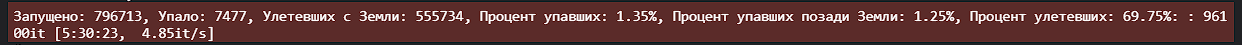

In [18]:
with open("probabilities.txt", "rb") as f:
    prob = pickle.load(f)

In [20]:
len(prob.traj)

50

In [25]:
prob.traj = prob.traj[:50]

In [22]:
def add_traj(trajectories, data=None):
    data = [] if data is None else data
    for traj in trajectories:
        X, Y, Z = traj
        data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                 marker=dict(
                                     size=0.1,
                                     color='orange',  # set color to an array/list of desired values
                                     colorscale=None,  # choose a colorscale
                                     opacity=0.8
                                 )
                                 )
                    )
    return data

In [23]:
with open("probabilities.txt", "rb") as f:
    prob = pickle.load(f)

In [42]:
data = add_traj(prob.traj[10:20])

In [43]:
data = make_Earth(data)
data = make_torus(data)

In [ ]:
plot_image(data)

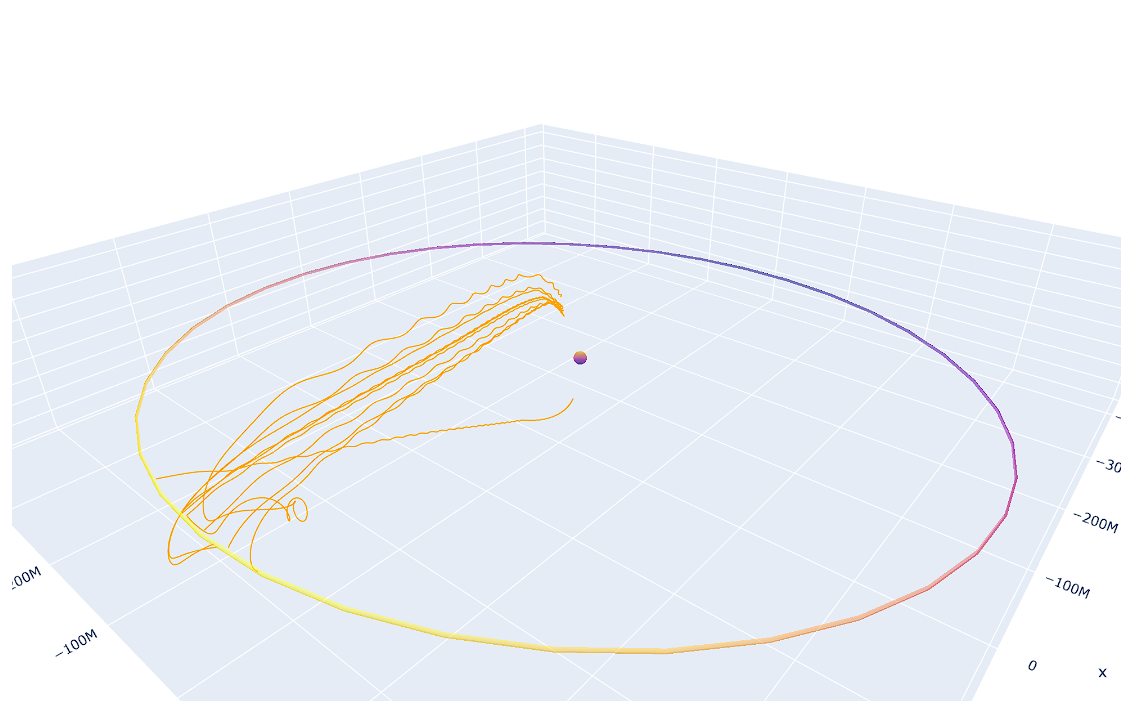

In [58]:
n, count, dep, count_behind = [], [], [], []
for i in range(0, len(prob.save), 4):
    n += [prob.save[i]]
    count += [prob.save[i+1]]
    dep += [prob.save[i+2]]
    count_behind += [prob.save[i+3]]
    
n = np.array(n)
count = np.array(count)
dep = np.array(dep)
count_behind = np.array(count_behind)

In [59]:
n

array([   1000,    5000,   10000,   50000,  100000,  500000, 1000000])

In [57]:
count

[8, 43, 107, 469, 964, 4688, 9331]

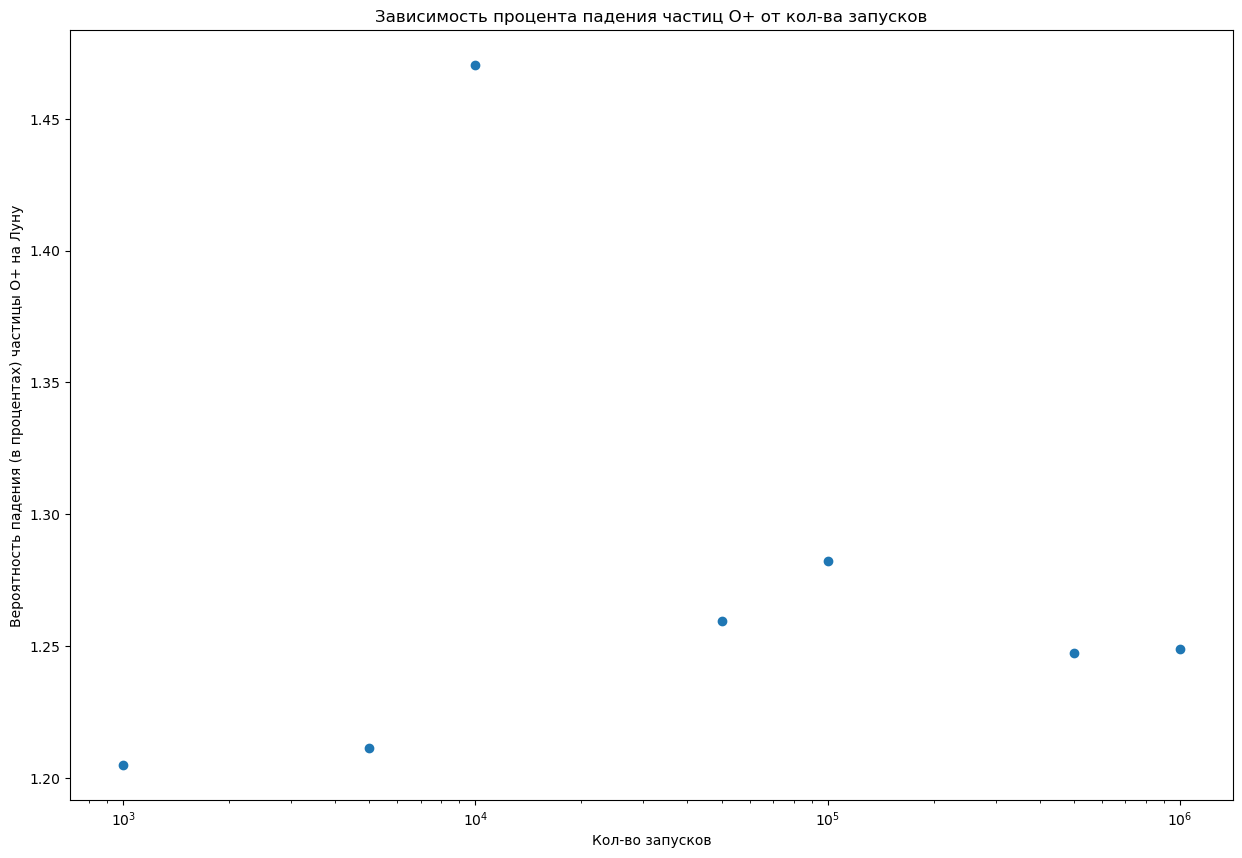

In [72]:
plt.figure(figsize=(15, 10))
plt.plot(n, count_behind / dep * 100, 'o')
plt.xscale('log')
plt.xlabel('Кол-во запусков')
plt.ylabel('Вероятность падения (в процентах) частицы O+ на Луну')
plt.title('Зависимость процента падения частиц O+ от кол-ва запусков');